# Analysing Results

In [2]:
import gzip
import os

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

from lcdb.analysis import read_csv_results
from lcdb.analysis import hyperparameters_from_row
from lcdb.analysis.plot import plot_learning_curves

# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues
from lcdb.analysis.json import QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryAnchorKeys
from lcdb.analysis.json import QueryEpochValues
from lcdb.analysis.json import QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix
from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [3]:
# source_csv = "output/lcdb.workflow.sklearn.RandomForestWorkflow/3/42-42-42/results.csv.gz"
# source_csv = "output/lcdb.workflow.sklearn.RandomForestWorkflow/1461/42-42-42/results.csv.gz"
source_csv = "output/lcdb.workflow.sklearn.RandomForestWorkflow/38/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:bootstrap,p:criterion,p:max_features,p:max_samples,p:min_impurity_decrease,p:min_samples_leaf,p:min_samples_split,p:n_estimators,p:pp@cat_encoder,p:pp@decomposition,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
70,True,gini,sqrt,1.000000,0.000000,2,2,100,ordinal,none,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
82,False,log_loss,log2,0.185325,0.465398,5,45,93,ordinal,ka_nystroem,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
60,False,gini,sqrt,0.261601,0.426128,7,19,76,ordinal,lda,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
186,False,entropy,sqrt,0.455253,0.729336,18,37,323,ordinal,kernel_pca,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
136,True,log_loss,log2,0.502897,0.839526,15,7,10,onehot,none,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,True,gini,sqrt,0.695731,0.997805,14,26,45,ordinal,lda,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
697,True,gini,log2,0.728211,0.079585,5,4,69,onehot,ka_nystroem,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
689,False,entropy,sqrt,0.145380,0.122247,1,44,32,onehot,agglomerator,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
686,True,log_loss,all,0.804974,0.201799,17,35,16,ordinal,none,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [4]:
r_df_failed

,p:bootstrap,p:criterion,p:max_features,p:max_samples,p:min_impurity_decrease,p:min_samples_leaf,p:min_samples_split,p:n_estimators,p:pp@cat_encoder,p:pp@decomposition,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
622,True,gini,log2,0.918689,0.271804,3,11,12,ordinal,agglomerator,...,38,42,lcdb.workflow.sklearn.RandomForestWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [5]:
print("Number of successful runs:", len(r_df))
print("Number of failed runs:", len(r_df_failed))

timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Number of successful runs: 698
Number of failed runs: 1
Experiment duration: 308.6928377151489 seconds


In [6]:
# Display the error of a failed job
idx = 0
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 67, in terminate_on_timeout
    return results.get(timeout)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 770, in get
    raise TimeoutError
multiprocessing.context.TimeoutError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 208, in fit_workflow_on_current_anchor
    self.workflow.fit(
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 69, in terminate_on_timeout
    raise FunctionCallTimeoutError(f"Search timeout expired after: {timeout}")
lcdb.utils.FunctionCallTimeoutError: Search timeout expired after: 300
"


In [23]:
r_df_failed.iloc[idx].to_dict()

{'p:bootstrap': True,
 'p:criterion': 'gini',
 'p:max_features': 'log2',
 'p:max_samples': 0.9186891768777636,
 'p:min_impurity_decrease': 0.2718044734855468,
 'p:min_samples_leaf': 3,
 'p:min_samples_split': 11,
 'p:n_estimators': 12,
 'p:pp@cat_encoder': 'ordinal',
 'p:pp@decomposition': 'agglomerator',
 'p:pp@featuregen': 'poly',
 'p:pp@featureselector': 'none',
 'p:pp@scaler': 'std',
 'p:pp@kernel_pca_kernel': 'linear',
 'p:pp@kernel_pca_n_components': 0.25,
 'p:pp@poly_degree': 5,
 'p:pp@selectp_percentile': 25,
 'p:pp@std_with_std': True,
 'objective': 'F_function_call_timeout_error',
 'job_id': 3,
 'm:timestamp_submit': 5.878981351852417,
 'm:timestamp_gather': 314.5716118812561,
 'm:timestamp_start': 1701367672.5369306,
 'm:timestamp_end': 1701367979.8130822,
 'm:memory': 253526411371,
 'm:openmlid': 38,
 'm:workflow_seed': 42,
 'm:workflow': 'lcdb.workflow.sklearn.RandomForestWorkflow',
 'm:valid_prop': 0.1,
 'm:test_prop': 0.1,
 'm:monotonic': True,
 'm:valid_seed': 42,
 'm:t

## Validation Error Rate vs. Number of Samples

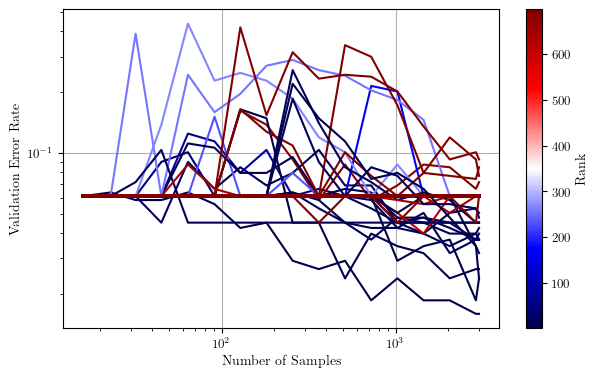

In [8]:
# Plot: Validation Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, error_rate_values, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Error Rate vs. Time

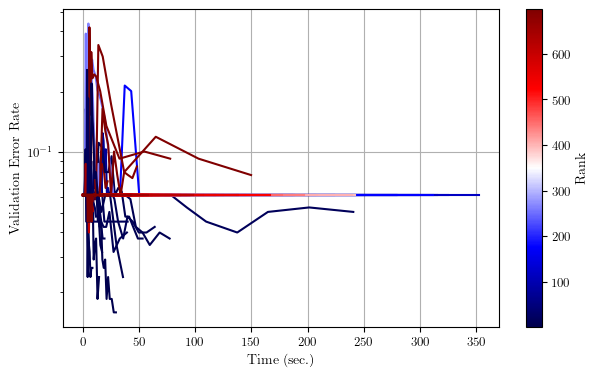

In [9]:
# Plot: Validation Error Rate vs. Time
# TODO: we may need to remove initial overheads to make all times start at 0.
source = r_df["m:json"]

query_anchor_timestamp_stop = QueryAnchorKeys("timestamp_stop")
timestamp_stop_values = source.apply(query_anchor_timestamp_stop).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))).to_list()

for i, (xi, yi) in enumerate(zip(timestamp_stop_values, error_rate_values)):
    timestamp_stop_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(timestamp_stop_values, error_rate_values, ax=ax)
ax.set_xlabel(f"Time (sec.)")
ax.set_ylabel(f"Validation Error Rate")
# ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_time.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Balanced Error Rate vs. Number of Samples

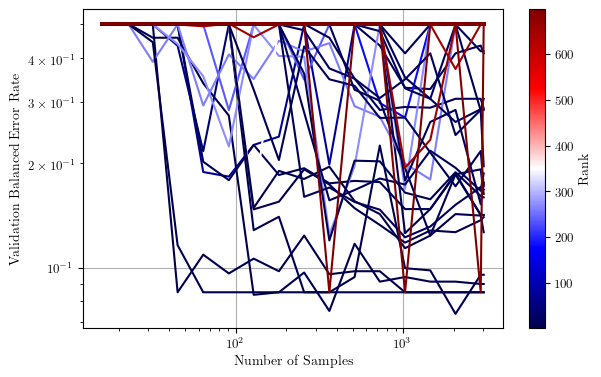

In [10]:
# Plot: Validation Balanced Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
balanced_error_rate_values = out.apply(lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, balanced_error_rate_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, balanced_error_rate_values, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Balanced Error Rate")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation LogLoss vs. Number of Samples

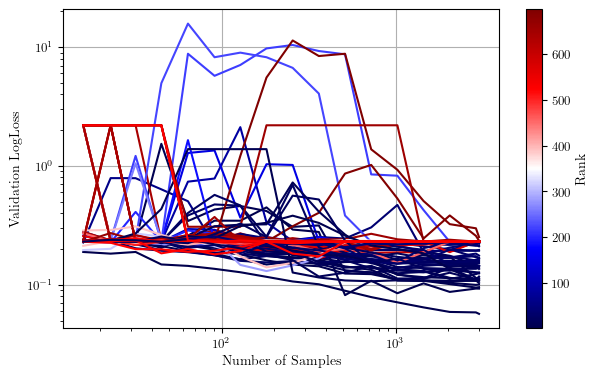

In [11]:
# Plot: Validation LogLoss vs. Time
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_log_loss_values = QueryMetricValuesFromAnchors("log_loss", split_name="val")
log_loss_values = source.apply(query_log_loss_values).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, log_loss_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, log_loss_values, alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation LogLoss")
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_log_loss_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Brier Score vs. Number of Samples

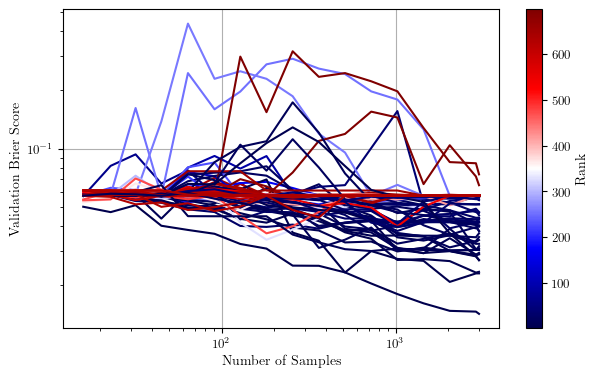

In [12]:
# Plot: Validation Brier Score vs. Time
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_brier_score_values = QueryMetricValuesFromAnchors("brier_score", split_name="val")
brier_score_values = source.apply(query_brier_score_values).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, brier_score_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, brier_score_values, alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Brier Score")
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_brier_score_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Error Rate vs. Number of Trees

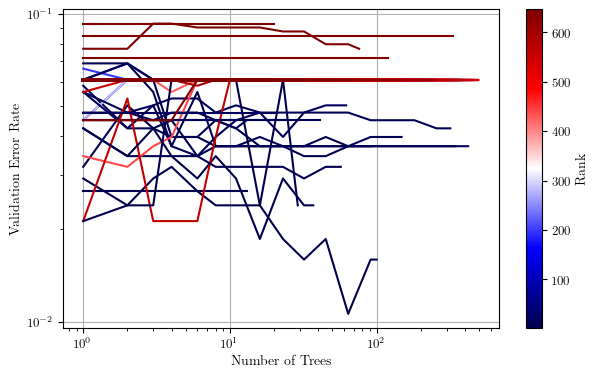

In [18]:
# Plot: Validation Error Rate vs. Number of Trees
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, error_rate_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, error_rate_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, error_rate_values, ax=ax)
ax.set_xlabel(f"Number of Trees")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_trees.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Validation Balanced Error Rate vs. Number of Trees

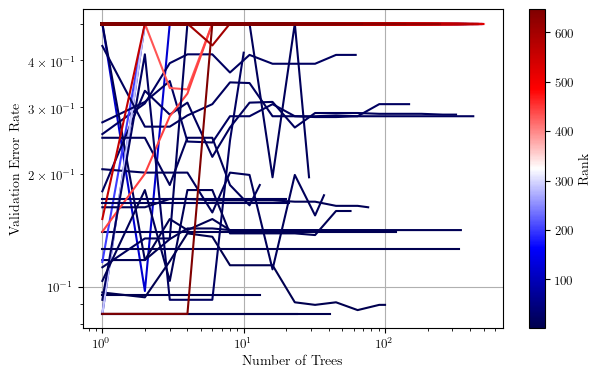

In [19]:
# Plot: Validation Balanced Error Rate vs. Number of Trees
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
berror_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, berror_rate_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, berror_rate_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, berror_rate_values, ax=ax)
ax.set_xlabel(f"Number of Trees")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_trees.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Validation LogLoss vs. Number of Trees

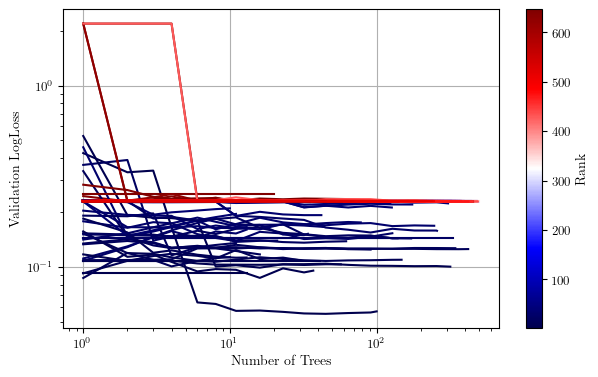

In [21]:
# Plot: Validation LogLoss vs. Number of Trees
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_log_loss_values = QueryMetricValuesFromEpochs("log_loss", split_name="val")
log_loss_values = source.apply(lambda x: query_log_loss_values(x)[-1]).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, log_loss_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, log_loss_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, log_loss_values, ax=ax)
ax.set_xlabel(f"Number of Trees")
ax.set_ylabel(f"Validation LogLoss")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_log_loss_vs_trees.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Validation Brier Score vs. Number of Trees

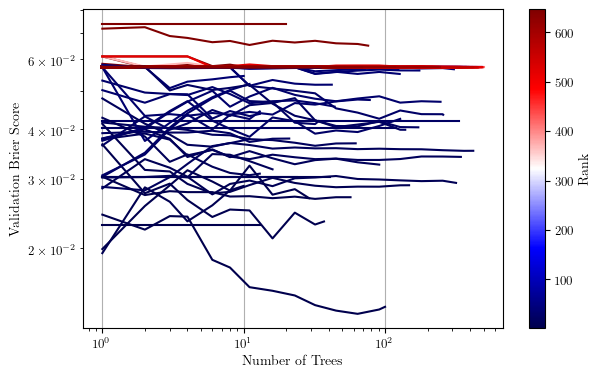

In [22]:
# Plot: Validation Brier Score vs. Number of Trees
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_brier_score_values = QueryMetricValuesFromEpochs("brier_score", split_name="val")
brier_score_values = source.apply(lambda x: query_brier_score_values(x)[-1]).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, brier_score_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, brier_score_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, brier_score_values, ax=ax)
ax.set_xlabel(f"Number of Trees")
ax.set_ylabel(f"Validation Brier Score")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_brier_score_vs_trees.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()